# FOSM - a brief overview (with equations!)

Throughout the previous tutorial notebooks we have explored how parameter estimation affects posterior parameter and forecast uncertainty. This notebook goes through some of the detail of how these uncertainties are calculated by PEST++ and `pyemu`. 

FOSM stands for "First Order, Second Moment", which is the mathematical description of what is being described. In PEST documentation (and other GMDSI tutorials), it is sometimes referred to as "linear analysis". See also page 460 in [Anderson et al. (2015)](https://linkinghub.elsevier.com/retrieve/pii/B9780080916385000018). 

> <div class="csl-entry">Anderson, M. P., Woessner, W. W., &#38; Hunt, R. J. (2015). Applied Groundwater Modeling: Simulation of Flow and Advective Transport. In <i>Applied Groundwater Modeling</i> (2nd ed.). Elsevier. https://linkinghub.elsevier.com/retrieve/pii/B9780080916385000018</div>

Pages 461-465 of Anderson et al. use the PREDUNC equation of PEST to discuss an applied view of FOSM, what goes into it, and what it means in practice.  Here we will look more closely at these.  The objective is to get a better feel for what is going on under the hood in linear uncertainty analyses. 

> __Side Note__: in Part2 of this series of tutorial notebooks we demonstrate a complete FOSM and Data-worth analysis workflow using `pyemu` and PEST++. The current notebook merely aims to provide a very high level introduction to some of the concepts.

<img src="intro_to_fosm_files\bayes.png" style="float: left; width: 25%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="intro_to_fosm_files\jacobi.jpg" style="float: left; width: 25%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="intro_to_fosm_files\gauss.jpg" style="float: left; width: 22%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="intro_to_fosm_files\schur.jpg" style="float: left; width: 22%; margin-right: 1%; margin-bottom: 0.5em;">
<p style="clear: both;">

FOSM provides approximate mathematical characterisation of prior predictive probability distributions, and of posterior parameter and predictive probability distributions. It has other uses as well. It can be used to demonstrate how the history-matching process bestows worth on data. It can also be deployed to track the flow of information from field measurements of system state to parameters, and ultimately from parameters to model predictions. 

It does all of these things by implementing Bayes equation under the following assumptions:
 -  The prior probability distribution of parameters is multiGaussian.
 - “Measurement noise” (including structural noise) is also characterized by a Gaussian distribution.
 - The relationships between model outputs that correspond to measurements of system state and parameters employed by a model can be approximated by the action of a matrix on a vector.
 - Model outputs that correspond to predictions of management interest can be calculated using another matrix that acts on model parameters.
 
Ideally linear analysis is undertaken after a model has been calibrated. However, if a model is truly linear (which it never is), the outcomes of FOSM are independent of parameter values and can therefore, in theory, be applied with the user-supplied prior mean parameter values.

If calibration has been undertaken, then minimum-error variance (i.e. calibrated) parameter values should be assigned to parameters as their initial parameters in the “parameter data” section of the PEST control file on which linear analysis is based. The Jacobian matrix should be calculated using these parameters. And, if the uncertainty of a prediction is going to be examined, then the model output that pertains to this prediction must be included as an “observation” in the PEST input dataset; sensitivities of this model output to model parameters will therefore appear in the Jacobian matrix.

FOSM tasks may include:
 - approximate parameter and predictive uncertainty quantification;
 - data worth analysis;
 - identifying parameters that are most salient for forecasts of interest, 
 - identifying parameter contributions to predictive uncertainty and 
 - assessing parameter identifiability. 

Outcomes of these analyses can provide easily understood insights into what history-matching can and cannot achieve with the available information. These insights can be used to streamline the data assimlation process and guide further site characterisation studies. Of particular interest is data worth analysis. The worth of data is measured by their ability to reduce the uncertainties of model predictions that we care about. Because the equations on which FOSM relies do not require that an observation value already be known, data worth can be assessed on as-of-yet ungathered data. 

But we are getting ahead of ourselves, let's take this back to basics.


## The famous Bayes Rule in a nutshell:

We update our knowledge by comparing what we know/believe with measured/observed data. What we know now, is a function of what we knew before, compared to what we learned from measured data.

### $\underbrace{P(\boldsymbol{\theta}|\textbf{d})}_{\substack{\text{what we} \\ \text{know now}}} \propto \underbrace{\mathcal{L}(\boldsymbol{\theta} | \textbf{d})}_{\substack{\text{what we} \\ \text{learned}}} \underbrace{P(\boldsymbol{\theta})}_{\substack{\text{what we} \\ \text{knew}}} $


We can also think of this graphically, as taken from Anderson et al. (2015) in slightly different notation but the same equation and concept:

<img src="intro_to_fosm_files\Fig10.3_Bayes_figure.png" style="float: center;width:500px;"/>

The problem is, for real-world problems, the likelihood function  $\mathcal{L}(\theta | \textbf{D})$ is high-dimensional and non-parameteric, requiring non-linear (typically Monte Carlo) integration for rigorous Bayes. Unfortunatley, non-linear methods are computationaly expensive and ineficient. 

But, we can make some assumptions and greatly reduce computational burden. This is why we often suggest using these linear methods first before burning the silicon on the non-linear ones like Monte Carlo.  

## How do we reduce the computational burden? 

By assuming that:

### 1. There is an approximate linear relation between parameters and observations:

<img src="intro_to_fosm_files\jacobi.jpg" style="float: left; width: 5%; margin-right: 1%; margin-bottom: 0.5em;">

### <center> $\mathbf{J} \approx \text{constant}$, $\frac{\partial\text{obs}}{\partial\text{par}} \approx \text{constant}$</center>

### 2. The parameter and forecast prior and posterior distributions are approximately Gaussian:

<img src="intro_to_fosm_files\gauss.jpg" style="float: left; width: 5%; margin-right: 1%; margin-bottom: 0.5em;">

###  <center>  $ P(\boldsymbol{\theta}|\mathbf{d}) \approx \mathcal{N}(\overline{\boldsymbol{\mu}}_{\boldsymbol{\theta}},\overline{\boldsymbol{\Sigma}}_{\boldsymbol{\theta}})$ </center>

Armed with these two assumptions, from Bayes equations, one can derive the Schur complement for conditional uncertainty propogation:

<img src="intro_to_fosm_files\schur.jpg" style="float: left; width: 5%; margin-right: 1%; margin-bottom: 0.5em;">

### <center> $\underbrace{\overline{\boldsymbol{\Sigma}}_{\boldsymbol{\theta}}}_{\substack{\text{what we} \\ \text{know now}}} = \underbrace{\boldsymbol{\Sigma}_{\boldsymbol{\theta}}}_{\substack{\text{what we} \\ \text{knew}}} - \underbrace{\boldsymbol{\Sigma}_{\boldsymbol{\theta}}\bf{J}^T\left[\bf{J}\boldsymbol{\Sigma}_{\boldsymbol{\theta}}\bf{J}^T + \boldsymbol{\Sigma}_{\boldsymbol{\epsilon}}\right]^{-1}\bf{J}\boldsymbol{\Sigma}_{\boldsymbol{\theta}}}_{\text{what we learned}}$ </center>

### Highlights:
1. There are no parameter values or observation values in these equations!
2. "us + data" = $\overline{\Sigma}_{\theta}$; "us" = $\Sigma_{\theta}$. This accounts for information from both data and expert knowledge.
3. The '-' on the right-hand-side shows that we are (hopefully) collapsing the probability manifold in parameter space by "learning" from the data. Or put another way, we are subtracting from the uncertainty we started with (we started with the Prior uncertainty)
4. Uncertainty in our measurements of the world is encapsulated in $\Sigma_{\epsilon}$. If the "observations" are highly uncertain, then parameter "learning" decreases because $\Sigma_{\epsilon}$ is in the denominator. Put another way, if our measured data are made (assumed) to be accurate and precise, then uncertainty associated with the parameters that are constrained by these measured data is reduced - we "learn" more. 
5. What quantities are needed? $\bf{J}$, $\boldsymbol{\Sigma}_{\theta}$, and $\boldsymbol{\Sigma}_{\epsilon}$
6. The diagonal of $\Sigma_{\theta}$ and $\overline{\Sigma}_{\theta}$ are the Prior and Posterior uncertainty (variance) of each adjustable parameter

# But what about forecasts? 

<img src="intro_to_fosm_files\jacobi.jpg" style="float: left; width: 5%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="intro_to_fosm_files\gauss.jpg" style="float: left; width: 5%; margin-right: 1%; margin-bottom: 0.5em;">
<p style="clear: both;"> We can use the same assumptions:
    
- prior forecast uncertainty (variance): $\sigma^2_{s} = \mathbf{y}^T\boldsymbol{\Sigma}_{\boldsymbol{\theta}}\mathbf{y}$
- posterior forecast uncertainty (variance): $\overline{\sigma}^2_{s} = \mathbf{y}^T\overline{\boldsymbol{\Sigma}}_{\boldsymbol{\theta}}\mathbf{y}$


### Highlights:
- Again, no parameter values or forecast values!
- What's needed? $\bf{y}$, which is the __sensitivity of a given forecast__ to each adjustable parameter. Each forecast will have its own $\bf{y}$.
- How do I get $\bf{y}$? the easiest way is to include your forecast(s) as an observation in the control file - then we get the $\bf{y}$'s for free during the parameter estimation process.

# Mechanics of calculating FOSM parameter and forecast uncertainty estimates

__in the PEST world:__

In the origingal PEST (i.e., not PEST++) documentation, FOSM is referred to as linear analysis. Implementing the various linear analyses relies a suite of utility software and a series of user-input-heavy steps, as illustrated in the figure below. 

<img src="intro_to_fosm_files\workflow.png" style="float: left; width: 50%; margin-right: 1%; margin-bottom: 0.5em;">



__in PEST++__:

In the PEST++ world, life is much easier. By default, PEST++GLM implements FOSM on-the-fly (it can be deactivated if the user desires) and records parameter and forecast uncertainties throughout the parameter estimation process.

Let's take a closer look and get a feel what is going on. 

# FOSM with PEST++ Demo

In the tutorial directory there is a folder containing the outcomes a PEST++GLM parameter estimation run. (These are based on the model and PEST setup constructed in the "_part1_freyberg_pilotpoints_" notebooks.) In the following section we will access several of these files using `pyemu`. It is assumed that the reader is familiar with the basics of `pyemu`.

Parameter estimation has already been undertaken with PEST++GLM. So we already have at our disposal a `jacobian matrix`, and the parameter and forecast uncertainty files written by PEST++GLM.

In [128]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import psutil
import shutil

sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import pyemu
import flopy
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd

plt.rcParams['font.size'] = 10
pyemu.plot_utils.font =10

The folder with model and pest files:


In [129]:
working_dir = "master_pp"

The PEST control file name:

In [130]:
pst_name = "freyberg_pp.pst"

Load the PEST control file:

In [131]:
pst = pyemu.Pst(os.path.join(working_dir, pst_name))

### Let's look at the parameter uncertainty summary written by pestpp:

PEST++GLM records a parameter uncertainty file named _casename.par.usum.csv_. It records the prior and posterior means, bounds and standard deviations.

In [132]:
df = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df.tail()

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
rch_i:22_j:7_zone:1.0,0.0,0.150515,-0.30103,0.30103,0.139262,0.149683,-0.160104,0.438628
rch_i:27_j:12_zone:1.0,0.0,0.150515,-0.30103,0.30103,-0.301030,0.150117,-0.601265,-0.000795
rch_i:2_j:17_zone:1.0,0.0,0.150515,-0.30103,0.30103,-0.301030,0.149932,-0.600894,-0.001166
rch_i:32_j:17_zone:1.0,0.0,0.150515,-0.30103,0.30103,-0.301030,0.149889,-0.600809,-0.001251
rch_i:32_j:2_zone:1.0,0.0,0.150515,-0.30103,0.30103,0.093792,0.149572,-0.205352,0.392936


We can visualize this with probability distributions. In the plot below, prior parameter distributions are shown by the dashed grey lines. Posterior parameter distributions are the blue shaded areas. Each plot shows distributions for parameters in the same group:

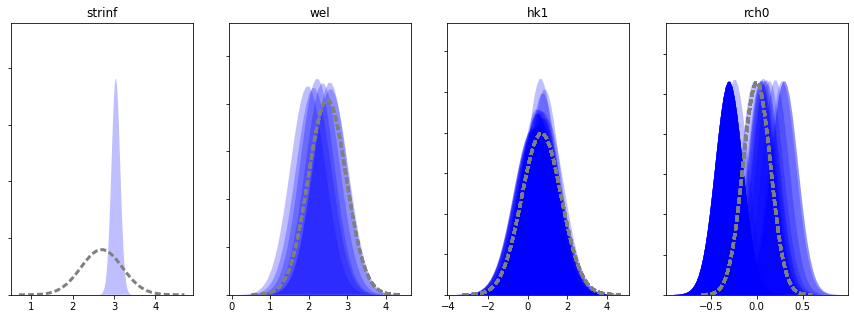

In [133]:
par = pst.parameter_data
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)

fig, axes=plt.subplots(1,len(pst.adj_par_groups),figsize=(15,5))

for pargp, ax in zip(pst.adj_par_groups, axes):
    hk_pars = [p for p in pst.par_names if p.startswith("hk")]
    pars = par.loc[par.pargp==pargp].parnme.values
    df_par = df_paru.loc[pars,:]
    ax = pyemu.plot_utils.plot_summary_distributions(df_par,label_post=False, ax=ax)
    mn = np.log10(pst.parameter_data.loc[pars[0].lower(),"parlbnd"])
    mx = np.log10(pst.parameter_data.loc[pars[0].lower(),"parubnd"])
    ax.set_title(pargp)

### There is a similar file for forecasts:
_casename.pred.usum.csv_

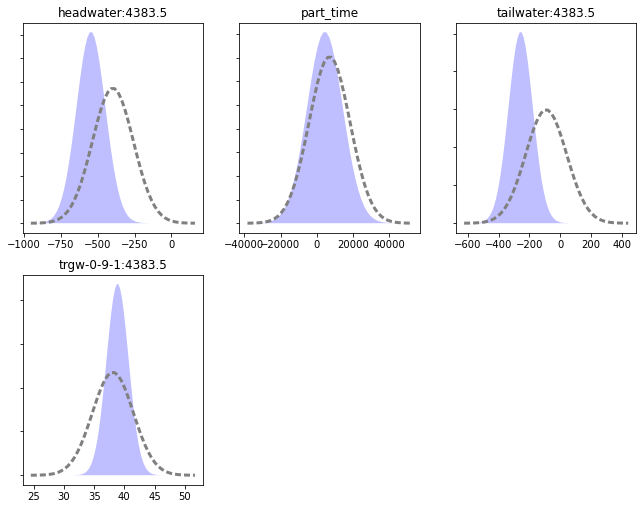

In [134]:
axes = pyemu.plot_utils.plot_summary_distributions(os.path.join(working_dir,pst_name.replace(".pst",".pred.usum.csv")),subplots=True)

### Where do the prior parameter distributions come from?

Prior parameter distributions can come from one of two sources. 

1. If no other information is provided, PEST++GLM assumes that all adjustable parameters are statistically independent. In this case, by default, the prior standard deviation of each parameter is calculated as a quarter of the difference between its upper and lower bounds in the PEST control file.(This is the case here)
2. Alternatively, the name of a prior parameter covariance matrix file can be provided to the `parcov()` control variable.


### Where do the prior forecast distributions come from?

At the first iteration of the parameter estimation process, PEST++GLM calculates sensitivities based on initial parameter values. These are used to determine the prior parameter and forecast uncertianty.


### Why are are the posterior distributions different than the priors?

Recall Bayes' Rule? By comparing model outputs to measured data we have "learnt" information about model parameters, thus "updating our prior" and reducing parameter (and forecast) uncertainty.


# FOSM with pyEMU

Now, `pyemu` does the same calculations, but also allows you to do other, more exciting things! 

We need three ingredients for FOSM:
 - parameter covariance matrix 
 - observation noise covariance matrix
 - jacobian matrix 


The ``Schur`` object is one of the primary object for FOSM in pyEMU and the only one we will talk about in this tutorial.

In [135]:
sc = pyemu.Schur(jco=os.path.join(working_dir,pst_name.replace(".pst",".jcb")),verbose=False)

Now that seemed too easy, right?  Well, underhood the ``Schur`` object found the control file ("freyberg_pp.pst") and used it to build the prior parameter covariance matrix, $\boldsymbol{\Sigma}_{\theta}$, from the parameter bounds and the observation noise covariance matrix ($\boldsymbol{\Sigma}_{\epsilon}$) from the observation weights.  These are the ``Schur.parcov`` and ``Schur.obscov`` attributes.  

The ``Schur`` object also found the "++forecasts()" optional pestpp argument in the control, found the associated rows in the Jacobian matrix file and extracted those rows to serve as forecast sensitivity vectors:

In [136]:
sc.pst.pestpp_options['forecasts']

'headwater:4383.5,tailwater:4383.5,trgw-0-9-1:4383.5,part_time'

### The Jacobian Matrix and Forecast Sensitivity Vectors

Recall that a Jacobian matrix looks at the changes in observations as a parameter is changed.  Therefore the Jacobian matrix has parameters in the columns and observations in the rows.  The bulk of the matrix is made up of the difference in  observations between a base run and a run where the parameter at the column head was perturbed (typically 1% from the base run value - controlled by the "parameter groups" info).  Now we'll plot out the Jacobian matrix as a `DataFrame`:

In [137]:
sc.jco.to_dataframe().loc[sc.pst.nnz_obs_names,:].head()

,strinf,wel5,wel2,wel3,wel0,wel4,wel1,hk_i:37_j:17_zone:1.0,hk_i:2_j:12_zone:1.0,hk_i:7_j:17_zone:1.0,...,rch_i:27_j:2_zone:1.0,rch_i:7_j:7_zone:1.0,rch_i:17_j:17_zone:1.0,rch_i:7_j:12_zone:1.0,rch_i:17_j:12_zone:1.0,rch_i:22_j:7_zone:1.0,rch_i:27_j:12_zone:1.0,rch_i:2_j:17_zone:1.0,rch_i:32_j:17_zone:1.0,rch_i:32_j:2_zone:1.0
gage-1:3652.5,2701.038074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.971740,40.977884,11.009388,...,233.676424,211.724770,123.321699,117.594619,139.492498,205.996115,111.374296,115.251205,111.504263,162.830857
gage-1:3683.5,2758.308084,-86.659532,-155.102373,-31.517565,-169.382321,-5.826344,-106.736092,-7.001878,43.820700,9.594664,...,250.884176,237.516400,138.562349,134.866725,154.983270,222.337450,121.609982,134.484108,121.495690,174.323931
gage-1:3712.5,2763.651532,-153.065906,-229.833407,-69.765689,-260.386165,-16.955436,-182.462445,-5.279506,48.268571,13.243102,...,255.074618,246.784476,158.764079,149.792602,171.531798,231.731411,136.843832,152.949590,141.695294,177.735497
gage-1:3743.5,2767.587759,-200.872396,-274.050449,-107.922063,-316.776331,-32.668267,-236.173369,-2.666389,56.340283,18.976361,...,262.372627,262.327398,183.524110,168.434459,192.757393,247.806710,155.281946,175.884650,165.510978,183.790415
gage-1:3773.5,2767.460005,-233.711911,-303.767106,-141.021466,-355.685448,-51.328687,-275.812356,-1.468689,64.846613,23.583199,...,285.028283,281.149104,202.481974,183.724911,210.789276,269.887488,169.771348,194.158371,182.279025,203.525390


This reports changes in observations to a change in a parameter.  We can report how  forecasts of interests change as the parameter is perturbed.  Note `pyemu` extracted the forecast rows from the Jacobian on instantiation:

In [138]:
sc.forecasts.to_dataframe()

,headwater:4383.5,tailwater:4383.5,trgw-0-9-1:4383.5,part_time
strinf,4.073027,14.781492,0.055031,-27.720583
wel5,11.195278,21.272294,-0.060499,-40.127323
wel2,10.333018,9.755094,-0.029345,-13.143477
wel3,22.048983,33.369486,-0.110435,-69.692920
wel0,13.286196,3.418764,-0.036648,11.879074
...,...,...,...,...
rch_i:22_j:7_zone:1.0,-34.386639,-28.170126,0.203734,1166.946035
rch_i:27_j:12_zone:1.0,-8.147812,-8.400744,0.047765,233.236941
rch_i:2_j:17_zone:1.0,-8.544833,-1.965742,0.042188,-154.946560
rch_i:32_j:17_zone:1.0,-1.691269,-2.295982,0.008608,42.451778


Each of these columns in a $\bf{y}$ vector used in the FOSM calculations...that's it! 

###  The prior parameter covariance matrix - $\boldsymbol{\Sigma}_{\theta}$

Because we have inherent uncertainty in the parameters, the forecasts also have uncertainty.  Here's what we have defined for parameter uncertainty - the Prior.  As discussed above, it was constructed on-the-fly from the parameter bounds in the control file: 

In [139]:
sc.parcov.to_dataframe()

,strinf,wel5,wel2,wel3,wel0,wel4,wel1,hk_i:37_j:17_zone:1.0,hk_i:2_j:12_zone:1.0,hk_i:7_j:17_zone:1.0,...,rch_i:27_j:2_zone:1.0,rch_i:7_j:7_zone:1.0,rch_i:17_j:17_zone:1.0,rch_i:7_j:12_zone:1.0,rch_i:17_j:12_zone:1.0,rch_i:22_j:7_zone:1.0,rch_i:27_j:12_zone:1.0,rch_i:2_j:17_zone:1.0,rch_i:32_j:17_zone:1.0,rch_i:32_j:2_zone:1.0
strinf,0.25,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
wel5,0.00,0.238691,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
wel2,0.00,0.000000,0.238691,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
wel3,0.00,0.000000,0.000000,0.238691,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
wel0,0.00,0.000000,0.000000,0.000000,0.238691,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rch_i:22_j:7_zone:1.0,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.022655,0.000000,0.000000,0.000000,0.000000
rch_i:27_j:12_zone:1.0,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.022655,0.000000,0.000000,0.000000
rch_i:2_j:17_zone:1.0,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.022655,0.000000,0.000000
rch_i:32_j:17_zone:1.0,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.022655,0.000000


> Page 463-464 in Anderson et al. (2015) spends some time on what is shown above.  

For our purposes, a diagonal Prior -  numbers only along the diagonal - shows that we expect the uncertainty for each parameter to only results from itself - there is no covariance with other parameters. The numbers themselves reflect "the innate parameter variability", and is input into the maths as a standard deviation around the parameter value.  This is called the "C(p) matrix of innate parameter variability" in PEST parlance.

> __IMPORTANT POINT__:  Again, how did PEST++ and pyEMU get these standard deviations shown in the diagonal?  From the *parameter bounds* that were specified for each parameter in the PEST control file.

### The  matrix  of observation noise - $C{\epsilon}$

Forecast uncertainty has to take into account the noise/uncertainty in the observations.   Similar to the parameter Prior - the $\Sigma_{\theta}$ matrix -, it is a covariance matrix of measurement error associated with the observations.  This is the same as  $\Sigma_{\epsilon}$ that we discussed above. For our Fryberg problem, sthe $C{\epsilon}$ matrix would look like:

In [140]:
sc.obscov.to_dataframe().loc[sc.pst.nnz_obs_names,sc.pst.nnz_obs_names].head()

,gage-1:3652.5,gage-1:3683.5,gage-1:3712.5,gage-1:3743.5,gage-1:3773.5,gage-1:3804.5,gage-1:3834.5,gage-1:3865.5,gage-1:3896.5,gage-1:3926.5,...,trgw-0-3-8:3743.5,trgw-0-3-8:3773.5,trgw-0-3-8:3804.5,trgw-0-3-8:3834.5,trgw-0-3-8:3865.5,trgw-0-3-8:3896.5,trgw-0-3-8:3926.5,trgw-0-3-8:3957.5,trgw-0-3-8:3987.5,trgw-0-3-8:4018.5
gage-1:3652.5,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gage-1:3683.5,0.0,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gage-1:3712.5,0.0,0.0,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gage-1:3743.5,0.0,0.0,0.0,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gage-1:3773.5,0.0,0.0,0.0,0.0,40000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> __IMPORTANT POINT__:  How did PEST++ and pyEMU get these standard deviations shown in the diagonal?  From the *weights* that were specified for each observation in the PEST control file.

> __IMPORTANT POINT__: You can use FOSM in the "pre-calibration" state to design an objective function (e.g. weights) to maximize forecast uncertainty reduction.

> __IMPORTANT POINT__: In PEST++, if a given observation has a larger-than-expected residual, the variance of said observation is reset to the variance implied by the residual.  That is, the diagonal elements of $\Sigma_{\epsilon}$ are reset according to the residuals

## Posterior Parameter Uncertainty - ${\overline{\boldsymbol{\Sigma}}_{\boldsymbol{\theta}}} $

Okay, enough emphasis.  Here's the point.  When we apply FOSM using the matrices above, we can see how our uncertainty changes during calibration, first for parameters and then for forecasts. 

Here, we are updating parameter covariance following notional calibration as represented by the Jacobian matrix and both prior parameter and observation noise covariance matrices. 

In other words, given prior parameter uncertainty (expressed by $\boldsymbol{\Sigma}_{\theta}$) and the inherent noise in measurments (expressed by $C{\epsilon}$), we calculate the expected parameter uncertainty __after__ calibration. This assumes that _calibration achieves a fit comensurate with measurement noise, parameter linearity, etc_.

The posterior parameter covariance matrix is stored as a `pyemu.Cov` object in the `sc.posterior_parameter` attribute. The diagonal of this matrix contains the posterior __variance__ for each parameter. The off-diagonals the parameter covariances. 

In [141]:
sc.posterior_parameter.to_dataframe().head()

,strinf,wel5,wel2,wel3,wel0,wel4,wel1,hk_i:37_j:17_zone:1.0,hk_i:2_j:12_zone:1.0,hk_i:7_j:17_zone:1.0,...,rch_i:27_j:2_zone:1.0,rch_i:7_j:7_zone:1.0,rch_i:17_j:17_zone:1.0,rch_i:7_j:12_zone:1.0,rch_i:17_j:12_zone:1.0,rch_i:22_j:7_zone:1.0,rch_i:27_j:12_zone:1.0,rch_i:2_j:17_zone:1.0,rch_i:32_j:17_zone:1.0,rch_i:32_j:2_zone:1.0
strinf,0.010940,0.008234,0.011111,0.007313,0.011918,0.004468,0.009479,0.003353,-0.001766,0.002128,...,-0.001475,-0.001525,-0.000624,-0.000730,-0.000804,-0.001262,-0.000608,-0.000629,-0.000526,-0.000955
wel5,0.008234,0.214184,-0.022602,-0.022136,-0.027432,-0.011711,-0.026360,-0.002423,0.007728,-0.000154,...,0.000510,0.000582,0.000167,0.000203,0.000286,0.000487,0.000133,0.000170,0.000088,0.000555
wel2,0.011111,-0.022602,0.208566,-0.012707,-0.035823,-0.003640,-0.028150,-0.001607,0.002173,-0.000198,...,0.000872,0.000971,0.000633,0.000570,0.000677,0.000949,0.000501,0.000621,0.000528,0.000698
wel3,0.007313,-0.022136,-0.012707,0.202598,-0.013659,-0.028413,-0.019645,-0.005123,0.006744,-0.005997,...,-0.000178,0.000092,-0.000492,-0.000311,-0.000208,0.000080,-0.000284,-0.000481,-0.000531,0.000177
wel0,0.011918,-0.027432,-0.035823,-0.013659,0.194261,-0.001432,-0.036984,-0.002131,0.001014,-0.001367,...,0.001230,0.001032,0.000616,0.000566,0.000683,0.001110,0.000490,0.000618,0.000489,0.000882


But...is calibration worth pursuing or not? Let's explore what the notional calibration is expected to do for parameter uncertainty. We accomplish this by comparing prior and posterior parameter uncertainty. Using `.get_parameter_summary()` makes this easy:

In [142]:
df = sc.get_parameter_summary()
df.head()

,prior_var,post_var,percent_reduction
strinf,0.250000,0.010940,95.624012
wel5,0.238691,0.214184,10.267575
wel2,0.238691,0.208566,12.620913
wel3,0.238691,0.202598,15.121355
wel0,0.238691,0.194261,18.614090


We can plot that up:

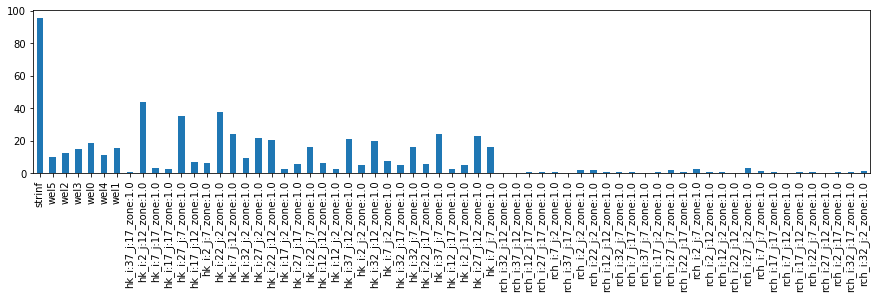

In [143]:
df.percent_reduction.plot(kind="bar", figsize=(15,3));

### Do these results make sense?  Why are some parameters unaffected by calibration?

As the name suggests, the `percent_reduction` column shows the  percentage decrease in uncertainty expected through calibration for each parameter.

From the plot above we can see that calibrating the model with available data definetly reduces uncertainty of some parameters. Some parameters are informed by observation data...however calibration does not affect all parameters equally. Available observation data does not contain information that affects these parameters. Calibration will not help us reduce their uncertainty.

##  Forecast Uncertainty

So far we have seen that some parameter uncertainty will be reduced. Uncertainty for other parameters will not. That's great and all, but what we really care about are our forecast uncertainties. Do the parameters that are informed by calibration affect the forecast of interest? And will calibrating reduce the uncertainty of these forecast?

Let's examine the prior and posterior variance of our forecasts. Recall that they are recorded as observations in the `Pst` control file and also listed in the pest++ `forecast` control variable:

In [144]:
forecasts = sc.pst.forecast_names
forecasts

['headwater:4383.5', 'tailwater:4383.5', 'trgw-0-9-1:4383.5', 'part_time']

As before, `pyemu` has already done much of the heavy-lifting. We can get a summary of the forecast prior and posterior variances with `.get_forecast_summary()`:

In [145]:
df = sc.get_forecast_summary()
df

,prior_var,post_var,percent_reduction
headwater:4383.5,1.938842e+04,9.634608e+03,50.307421
tailwater:4383.5,1.776643e+04,6.239581e+03,64.879930
trgw-0-9-1:4383.5,1.152812e+01,3.330937e+00,71.105995
part_time,1.283893e+08,9.700290e+07,24.446282


And we can make a cheeky little plot of that. As you can see, unsurprisingly some forecasts benefit more from calibration than others. So, depending on the foreacst of interest, calibration may or may not be worthwhile...

Text(0.5, 0, 'forecast')

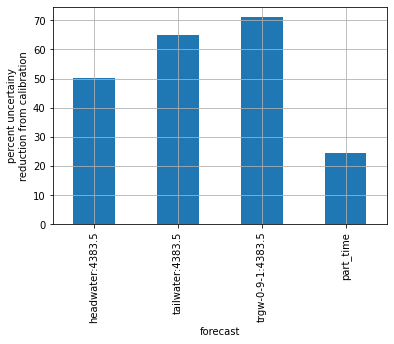

In [146]:
# get the forecast summary then make a bar chart of the percent_reduction column
fig = plt.figure()
ax = plt.subplot(111)
ax = df.percent_reduction.plot(kind='bar',ax=ax,grid=True)
ax.set_ylabel("percent uncertainy\nreduction from calibration")
ax.set_xlabel("forecast")

## Parameter contribution to forecast uncertainty

Information flows from observations to parameters and then out to forecasts. Information contained in observation data constrains parameter uncertainty, which in turn constrains forecast uncertainty. For a given forecast, we can evaluate which parameter contributes the most to uncertainty. This is accomplished by assuming a parameter (or group of parameters) is perfectly known and then assessing forecast uncertainty under that assumption. Comparing uncertainty obtained in this manner, to the forecast uncertainty under the base assumption (in which no parameter is perfectly known), the contribution from that parameter (or parameter group) is obtained. 

Now, this is a pretty big assumption - in practice a parameter is never perfectly known. Nevertheless, this metric can provide usefull insights into the flow of information from data to forecast uncertainty, which can help guide data assimilation design as well as future data collection efforts. 

In `pyemu` we can  evaluate parameter contributions to forecast uncertainty with groups of parameters by type using `.get_par_group_contribution()`:

In [147]:
par_contrib = sc.get_par_group_contribution()
par_contrib.head()

,headwater:4383.5,tailwater:4383.5,trgw-0-9-1:4383.5,part_time
base,9634.608097,6239.581136,3.330937,9.700290e+07
hk1,518.792274,182.281668,0.019636,1.853932e+06
rch0,8061.537145,6046.316473,3.295668,9.572361e+07
strinf,9292.612485,6210.352972,3.271126,9.647711e+07
wel,9555.265437,6086.164194,3.324232,9.663356e+07


We can see the relatve contribution by normalizing to the base case (e.g. in which no parameters/groups are perfectly known):

In [148]:
base = par_contrib.loc["base",:]
par_contrib = 100.0 * (base - par_contrib) / base
par_contrib.sort_index().head()

,headwater:4383.5,tailwater:4383.5,trgw-0-9-1:4383.5,part_time
base,0.000000,0.000000,0.000000,0.000000
hk1,94.615326,97.078623,99.410498,98.088788
rch0,16.327296,3.097398,1.058811,1.318816
strinf,3.549658,0.468432,1.795606,0.542035
wel,0.823517,2.458770,0.201289,0.380751


Understanding the links between parameters and forecast uncertainties can be usefull - in particular to gain insight into the system dynamics. But we are still missing a step to understand what _observation_ data affects the forecast. It is often more straightforward to quantify how observation information imapcts forecast uncertianty so that we can explore the worth of observation data directly.

# Data worth analysis

> __Note__: We will _not_ demonstrate data worth analysis here. See the respective notebook in Part2 of these tutorials.

The worth of data is measured by their ability to reduce the uncertainties of model predictions that we care about. Linear analysis is particularly useful for exploring data worth. This is because the equations that it uses to calculate predictive uncertainty do not include terms that represent the actual values of observations or of parameters; only sensitivities of model outputs to parameters are required. Therefore, linear analysis can be used to assess the ability (or otherwise) of yet-ungathered data to reduce the uncertainties of decision-critical predictions.

### <center> This is __Huge__. Let me say it again.<center>

#### <center>  We can assess the relative worth of an observation ___without knowing the value of the observation___. </center>


This means that potential field measurements that correspond to one or many outputs of a model can be assessed for their worth. For example, it is possible to assess the worth of observations of head in every single model cell at every time step of a model run with a relatively small computational burden. This makes linear analysis a useful tool for designing and comparing strategies for data-collection, when data acquisition seeks to reduce the uncertainties of one or a number of decision-critical predictions. 

There are two main applications for data worth analysis:
 1.	ranking of the relative worth of existing observations by calculating predictive uncertainty with selected individual or combined observations removed from a calibration dataset. 
 2.	ranking of the relative worth of __potential__ new observations by calculating predictive uncertainty with selected individual or combined observations added to an existing calibration dataset.